# Clustering

The goal of this program is to visualize and cluster the data.

## Input
* Importing the libaries that are necessary:

In [1]:
import numpy as np

* Importing the necessary files:
 * Read files
 * Convert read files to data
 * Save data in dataframes

In [2]:
def lib(FileName):
    def openFile(FileName):
        read_data = open(f'{FileName}')
        data = read_data.read()
        data = data.splitlines()
        read_data.close()
        
        return data
        
    lib = {}
    
    for lines in openFile(FileName):
        line = lines.split()
        if len(line[1:]) == 1:
            lib[int(line[0])] = int(line[1])
        else:
            lib[int(line[0])] = line[1:]
            
    return lib
            
lib_data = lib('Data\Voorbeeld_clusterdata.txt')
lib_results = lib('Data\Voorbeeld_clusterresult.txt')

## Cluster methods
### K-means (KMCA):

K-means is een clustermethode dat is gebasseerd op de afstand van een punt tot een centroid (middelpunt). De variabele k bepaald hoeveel centroids er zijn. In deze variant van K-means clusteren wordt de al genormaliseerde data nog eens genormaliseerd zodat de afstand van elk eiwit-ID gelijk is aan 1. Dit houdt in dat de waardes van eiwit-ID's naar vectoren zijn omgerekend. 
Vervolgens krijgt elke vector een random cluster aangewezen in range(1,k+1). 

Vervolgens wordt de afstand van elke vector tot de centroids berekend. De korste afstand van een vector tot een centroid is waarop een cluster is gebasseerd. Voor elke eiwitvector wordt dit gedaan en zo wordt alles ingedeeld. Vervolgens wordt voor elke cluster de gemiddelde vector/cordinaten bepaald en de uitkomst van dit gemiddelde is de nieuwe plek van een centroid. 

Het proces van afstanden bepalen, cluster toekennen en vervolgens nieuwe centroid locaties berekenen en toekennen blijft herhaald worden totdat de E-score niet meer lager wordt. De E-score zegt iets over de 'goodness' van de K-means cluster methode, dus wanneer de cluster methode het beste resultaat geeft moet het stoppen. 

In [3]:
class KMCA:
    def __init__(self, k=6, seed=20):
        '''
        preconditions:  The number of clusters for, the number of seed for seed, the maximum number of times
                        you want to itterate over the data
        postconditions: sets the number of clusters to self.k
                        sets the number of seeds to self.seed
        '''
        self.k = k + 1
        self.seed = seed
    
    def fit(self, data):
        '''
        preconditions:  a library with that contains the data. the library must have tehe gene code as key and a list
                        of the datapoints as value.
        postconditions: returns a library: 
                            keys   --> clusters
                            values --> genes that are classefied in that cluster
        this functions task: to assign all genes to its right cluster.
        '''
        
        self.input_data = data
        
        def E_score():
            '''
            preconditions:  /
            postconditions: returns the e_score as an integer.
            this functions task: calculate the e_score for the clusterd genes 
            '''
            
            mean = 0

            for k in range(1,self.k):
                score = np.sum([np.square(abs(np.subtract(self.centroids[k], self.lib_norm[dis]))) for dis in self.labeled_data[k]])
                mean += score

            e_score = mean / self.k

            return e_score

        def normalize():
            '''
            preconditions:  /
            postconditions: sets the normalised coordinates as content for the variable self.lib_norm
            this functions task: normalise the coordinates of all genes
            '''
            
            normalized = dict()
            for i in data:
                norm = np.sqrt(np.sum(np.square(np.array(data[i]).astype(float))))
                normalized[i] = np.divide(np.array(data[i]).astype(float), norm)
            
            self.lib_norm = normalized
        
        
        def rand_label():
            '''
            preconditions:  /
            postconditions: returs a library:
                                keys   --> cluster
                                values --> genes that are random classefied to that cluster
            this functions task: random assigning genes to a cluster
            '''
            
            labeld_data = dict()
            labels_id = dict()
            np.random.seed(self.seed)
            labels = np.random.randint(1,self.k,len(self.lib_norm))

            for i in range(len(self.lib_norm)):
                labeld_data[list(self.lib_norm.keys())[i]] = labels[i]

            for K in range(1,self.k):
                labels_id[K] = np.array([i for i,j in labeld_data.items() if j == K])
            
            return labels_id
            
        def centroid():
            '''
            preconditions:  /
            postconditions: returns a library:
                                keys   --> cluster
                                values --> list of coordinats for the center of that cluster
            this functions task: calculating the centers of the clusters
            '''
            
            centroids = dict()

            for k in range(1,self.k):
                centroids[k] = np.mean(np.array([self.lib_norm[index] for index in self.labeled_data[k]]), axis=0)

            return centroids
        
        def assign_cluster(unlabeld_data):
            '''
            preconditions:  a library:
                                keys  --> gen
                                value --> the normalised coordinates of the gen
            postconditions: a library:
                                keys  --> cluster
                                value --> genes classified to that cluster                     
            this functions task: assigning genes to the cluster with the nearest center
            '''
            
            lib_clust = {k:[] for k in range(1,self.k)}
            
            for cords in unlabeld_data:
                clust = np.argmin([np.sqrt(np.sum(np.square(np.subtract(self.centroids[k],unlabeld_data[cords])))) for k in range(1,self.k)])+1
                lib_clust[clust].append(cords)

            return lib_clust
        
        norm = normalize()
        self.labeled_data = rand_label()
        self.centroids = centroid()
        self.E_score = E_score()
        
        optimized = False
        
        while optimized == False:
            self.labeled_data = assign_cluster(self.lib_norm)

            self.centroids = centroid()
            new_e_score = E_score()

            if self.E_score > new_e_score:
                self.E_score = new_e_score
            else:
                optimized = True
                    
        return self.labeled_data
    
    def optimize(self, min_seed=0, max_seeds=30):
        '''
        preconditions:  min,max seed: range to loop the seeds in
        postconditions: a library:
                            keys  --> cluster
                            value --> genes classified to that cluster                     
        this functions task: assigning genes to the cluster with the best centroids
        '''
        old_e = float('inf')
        
        for seed in range(min_seed,max_seeds+1):
            self.seed = seed
            self.fit(self.input_data)
            new_e = self.E_score
            
            if new_e < old_e:
                best_labeld_data = self.labeled_data
                best_seed = seed
                old_e = new_e
                
        self.seed = best_seed
        
        return best_labeld_data, best_seed, old_e
        
    
    def predict(self, input_data):
        lib_clust = {k:[] for k in range(1,self.k)}
        
        if type(input_data) == dict:
            for cords in input_data:
                norm = np.sqrt(np.sum(np.square(np.array(input_data[cords]).astype(float))))
                normalized = np.divide(np.array(input_data[cords]).astype(float), norm)

                clust = np.argmin([np.sqrt(np.sum(np.square(np.subtract(self.centroids[k],normalized)))) for k in range(1,self.k)])+1
                lib_clust[clust].append(cords)
                
        if type(input_data) == list:
            norm = np.sqrt(np.sum(np.square(np.array(input_data).astype(float))))
            normalized = np.divide(np.array(input_data).astype(float), norm)
            
            clust = np.argmin([np.sqrt(np.sum(np.square(np.subtract(self.centroids[k],normalized)))) for k in range(1,self.k)])+1
            lib_clust[clust].append(normalized)
            
        return lib_clust

In [4]:
proberen = 17
oke = KMCA(k=6,seed=proberen)
res = oke.fit(lib_data)
res_e_score = oke.E_score
best_results, best_seed, best_e_score = oke.optimize(0,30)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [5]:
print(f'Seed: {proberen}, geeft E-score: {res_e_score}')
for cluster in res:
    print(f'cluster {cluster}: heeft {len(res[cluster])} data punten in zich')

Seed: 17, geeft E-score: 19.600665734194376
cluster 1: heeft 351 data punten in zich
cluster 2: heeft 136 data punten in zich
cluster 3: heeft 96 data punten in zich
cluster 4: heeft 36 data punten in zich
cluster 5: heeft 150 data punten in zich
cluster 6: heeft 243 data punten in zich


In [6]:
print(f'De beste seed: {best_seed}, geeft E-score: {best_e_score}')
for cluster in best_results:
    print(f'cluster {cluster}: heeft {len(best_results[cluster])} data punten in zich')

De beste seed: 30, geeft E-score: 19.5450626826176
cluster 1: heeft 94 data punten in zich
cluster 2: heeft 36 data punten in zich
cluster 3: heeft 243 data punten in zich
cluster 4: heeft 136 data punten in zich
cluster 5: heeft 84 data punten in zich
cluster 6: heeft 419 data punten in zich


In [7]:
oke.predict([-0.296,-0.503,-0.454,-0.868,-0.721,-0.918,-0.486,-0.582])

{1: [array([-0.16450411, -0.27954584, -0.25231374, -0.4823972 , -0.4007009 ,
         -0.51018505, -0.27009797, -0.32345066])],
 2: [],
 3: [],
 4: [],
 5: [],
 6: []}

### Grid based Cluster Algorithm (GCA)
Grid gebaseerd clusteren is clusteren op cellen en buurcellen in een n-dimensionale ruimte. Dit gebeurd doormiddel van 'sub-spaces' te maken. Dit houdt in dat elke dimensie in de range van n-dimensies wordt opgesplitst in hokjes.

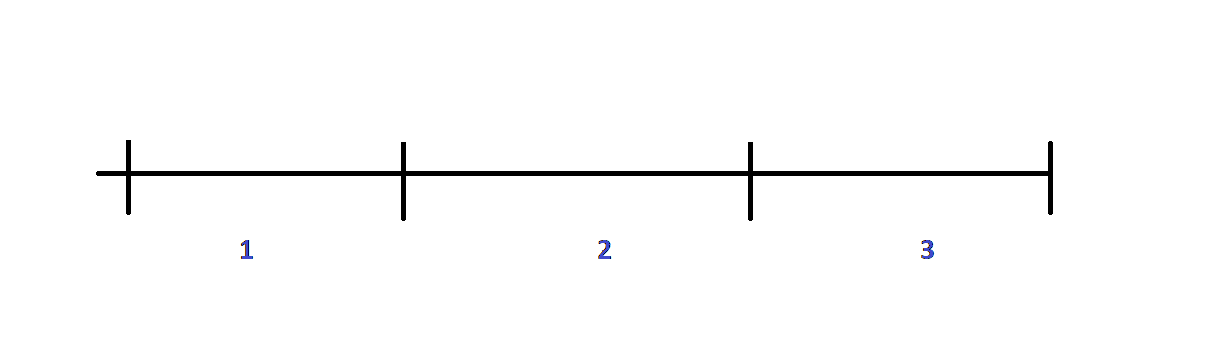

Elk hokje krijgt een cijfer in range(0, n-hokjes). Als dit voor elke dimensie wordt gedaan ontstaat er een unieke code die voor elke mogelijke cel in een n-dimensionale-grid staat. Zo'n cel-ID ziet er als volgt uit:
>    `[range(0, n-hokjes),...,range(0, n-hokjes)]`

In een twee-dimensionale ruimte ziet dit er als volgt uit:

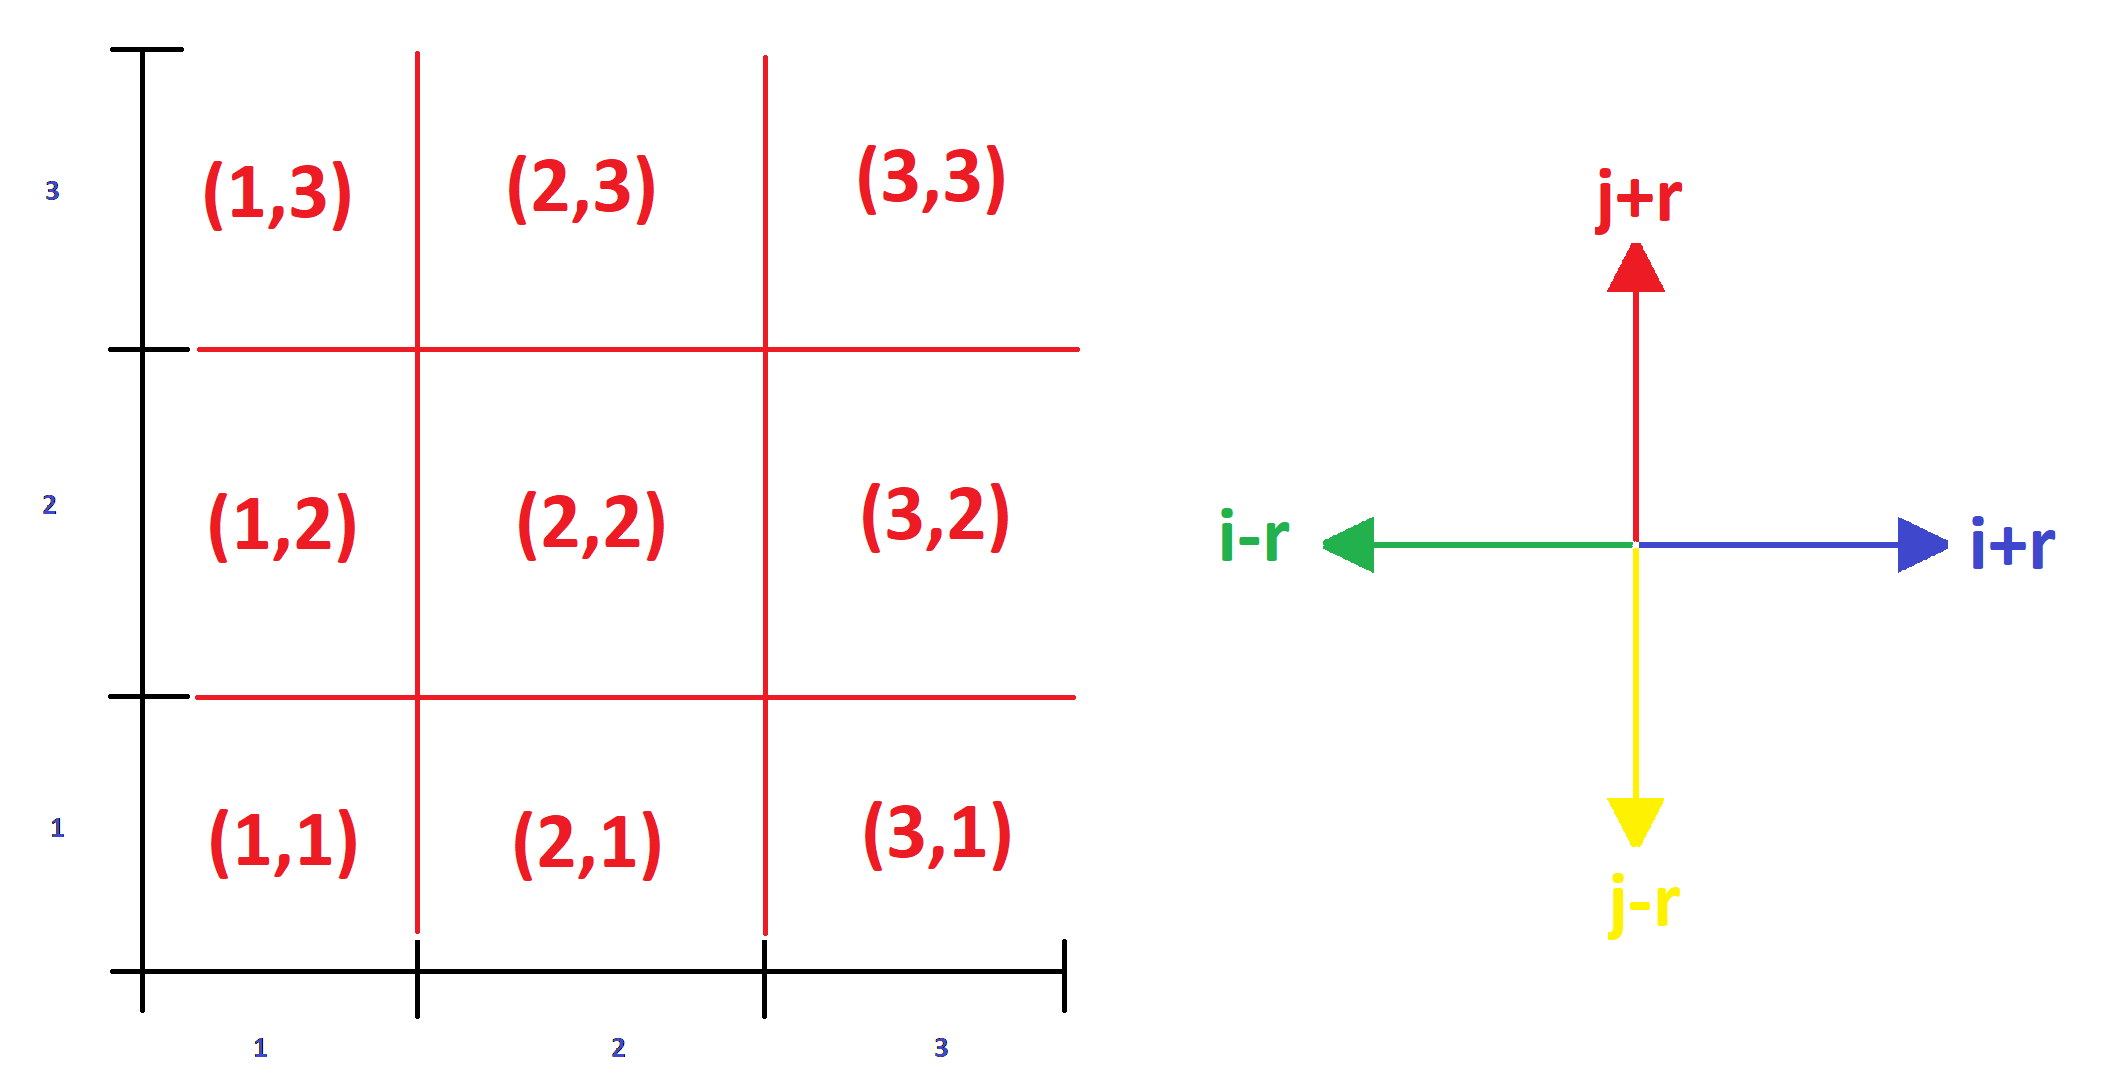

De buren van een cel kan berekend worden door de maximale range (r) waarin je buren wilt zoeken doormiddel van de orginele cel af te trekken van elk andere celID die er is. Dit geeft een lijst met getallen. Als elk van deze getallen in deze lijst binnen de opgestelde range vallen kan het als een buurcel gerekend worden.

De laatste stap is om het berekenen van buurcellen te herhalen totdat er geen buurcellen meer zijn. Als er geen buurcellen meer zijn gaat het algrotime naar een volgende unieke cel en begint daar de buren van te bepalen. Zo ontstaan er groepen buren, aldus clusters.

In [8]:
class GCA:    
    def __init__(self, r=1, j=10, tresh=4):
        '''
        preconditions:  The range of neigbors (r), the total amount of sub-spaces per axis (j), the treshhold on how many 
                        points there need to be per cel to count it as clustercel (tresh).
        postconditions: sets the range to self.r
                        sets the amount of sub-spaces to self.j
                        sets the treshhold to self.tresh
        '''
        self.r = r
        self.j = j
        self.tresh = tresh    
    
    def fit(self, data):
        '''
        preconditions:  a library with that contains the data. the library must have the gene code as key and a list
                        of the datapoints as value.
        postconditions: returns a library: 
                            keys   --> clusters
                            values --> unique cell ID
        this functions task: to assign all genes to a cell.
        '''
        self.indexes = list(data.keys())

        def get_cordinates(data):
            '''
            preconditions:  a library with that contains the data. the library must have tehe gene code as key and a list
                            of the datapoints as value.
            postconditions: returns a library: 
                                keys   --> axis
                                values --> list of all values in that specific axis
            this functions task: returning a library with as key every axis and as value a list of all value of the axis.
            '''
            cordinates = dict()

            for cor in range(len(data[self.indexes[0]])):
                x = list()
                for i in data:
                    x.append(float(data[i][cor]))

                cordinates[cor] = tuple(x)
            return cordinates

        def get_intervals(data,j):
            '''
            preconditions:  a library that contains the axis-data.
            postconditions: return per axis the intervals of the subspaces
            this functions task: returning a library with the subspaces of the data sorted on the axis.
            '''
            dic = dict()

            for i in data:
                minim = np.min(data[i])
                maxim = np.max(data[i])

                dic[i] = np.mgrid[minim:maxim:complex(0,j)]

            return dic

        def get_cells():
            '''
            preconditions:  - a library with that contains the data. the library must have tehe gene code as key and a list
                              of the datapoints as value. 
                            - a library with the intervals
                            
            postconditions: returns a library: 
                                keys   --> gene ID
                                values --> unique cel ID
            this functions task: returning a library with gene ID as key and as value the unique cel ID.
            '''
            cordinates = get_cordinates(data)
            intervals = get_intervals(cordinates,self.j)
            
            labels = list()
            for i in cordinates:
                x_inter_label = list()
                for j in range(1,len(intervals[i])):
                    vals = list((cordinates[i] >= intervals[i][j-1]) & (cordinates[i] < intervals[i][j]))
                    vals = np.where(vals==False, 0, vals)
                    vals = np.where(vals==True, j, vals)       

                    x_inter_label.append(vals)

                labels.append(x_inter_label)


            labelzz = list()
            for i in range(len(labels)):
                for k in range(1,len(labels[i])):
                    labels[i][0] = np.add(labels[i][0],labels[i][k])
                labelzz.append(labels[i][0])

            del labels

            self.lib_cells = dict()     

            for i in range(len(labelzz[0])):
                cell_id = list()
                for j in range(len(labelzz)):
                    cell_id.append(labelzz[j][i])

                self.lib_cells[self.indexes[i]] = cell_id
            
            
            return self.lib_cells
        return get_cells()
        
    def self_predict(self, cell_ids):
        '''
        preconditions:  a library with that contains the data. the library must have the gene code as key and a list
                        of the datapoints as value.
        postconditions: returns a library: 
                            keys   --> clusters
                            values --> genes that are classefied in that cluster
        this functions task: to assign all genes to its right cluster.
        '''
        def get_neigb_id(ID):
            '''
            preconditions:  a cell ID.  
            postconditions: returns a list with all the IDs of the neigboring cells
            this functions task: returning neigbor cel IDs.
            '''
            neigb = list()
            for indx in cell_ids:
                distance = np.subtract(self.lib_cells[ID],self.lib_cells[indx],out=np.array([0 for i in range(8)]))
                if all([-self.r < i < self.r for i in distance]):
                    neigb.append(indx)

            return neigb

        new_indexes = self.indexes.copy()

        def make_groups(data_point):
            '''
            preconditions:  a cell ID.  
            postconditions: returns a list with all the neigbors of neigbors that originated from the first cell
            this functions task: returning a cluster/group.
            '''
            neigbors = get_neigb_id(data_point)
            new_neigbors = list()

            for cel in neigbors:
                new_cells = get_neigb_id(cel)

                for new_cel in new_cells:
                    if new_cel not in neigbors:
                        new_neigbors.append(new_cel)
                        print(new_cel)

                neigbors += new_neigbors

            for neigb in neigbors:
                new_indexes.remove(neigb)

            return neigbors

        options = list()

        for index in new_indexes:
            options.append(make_groups(index))


        self.labeled_data = dict()
        cluster = 0
        anti_cluster = -1

        for i in range(len(options)):
            if len(options[i]) > self.tresh:
                self.labeled_data[cluster] = options[i]
                cluster += 1
            else:
                self.labeled_data[anti_cluster] = options[i]
                anti_cluster -= 1

        return self.labeled_data        

In [9]:
gca = GCA()
fitted_data = gca.fit(lib_data)
results = gca.self_predict(fitted_data)

In [10]:
for cluster in results:
    print(f'cluster {cluster}: heeft {len(results[cluster])} data punten in zich')

cluster 0: heeft 10 data punten in zich
cluster 1: heeft 20 data punten in zich
cluster 2: heeft 53 data punten in zich
cluster -1: heeft 4 data punten in zich
cluster 3: heeft 5 data punten in zich
cluster 4: heeft 7 data punten in zich
cluster 5: heeft 22 data punten in zich
cluster 6: heeft 10 data punten in zich
cluster -2: heeft 4 data punten in zich
cluster 7: heeft 8 data punten in zich
cluster -3: heeft 1 data punten in zich
cluster -4: heeft 1 data punten in zich
cluster 8: heeft 28 data punten in zich
cluster 9: heeft 19 data punten in zich
cluster 10: heeft 12 data punten in zich
cluster 11: heeft 33 data punten in zich
cluster 12: heeft 15 data punten in zich
cluster 13: heeft 7 data punten in zich
cluster 14: heeft 7 data punten in zich
cluster 15: heeft 17 data punten in zich
cluster -5: heeft 2 data punten in zich
cluster -6: heeft 1 data punten in zich
cluster 16: heeft 13 data punten in zich
cluster -7: heeft 2 data punten in zich
cluster 17: heeft 60 data punten in zi